# ECE1513 practical session 5: Validaiton and finetuning!



## Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms


## Dataset

The MNIST dataset is a famous dataset in machine learning and computer vision, consisting of 28x28 grayscale images of handwritten digits (0 through 9). Each image is associated with a label indicating the digit it represents.

Here's an introduction to the MNIST dataset along with Python code to load it using PyTorch and visualize some sample images:

In [2]:
# Define a transformation to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


100%|██████████| 9912422/9912422 [00:00<00:00, 64987231.37it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72276666.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25585131.82it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12330439.33it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Dataloader

PyTorch DataLoader is an essential component when working with large datasets in deep learning. Here are some reasons why PyTorch DataLoader is important:

* Efficient Data Loading: DataLoader efficiently loads data in batches, allowing you to work with large datasets that may not fit entirely into memory. It loads data in parallel using multiple workers, which can significantly speed up the training process.

* Batch Processing: Deep learning models often train on batches of data rather than individual samples. DataLoader automatically batches the data according to the specified batch size, making it easy to train models with mini-batch gradient descent.

* Shuffling: DataLoader can shuffle the data during training, which is crucial for preventing the model from memorizing the order of the data. Shuffling helps in generalization and improves the model's performance on unseen data.

* Data Transformation: DataLoader allows you to apply data transformations (e.g., normalization, resizing, data augmentation) on the fly. This helps in preprocessing the data before feeding it into the model, enhancing the model's robustness and performance.

* Integration with PyTorch Models: DataLoader seamlessly integrates with PyTorch models and training loops. It provides an iterable interface that can be easily used in training loops to iterate over batches of data.

* Customization: DataLoader is highly customizable and can be configured with various parameters such as batch size, shuffle, number of workers, and drop last batch. This flexibility allows you to tailor the data loading process according to your specific requirements.

In [3]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
for batch_idx,(data , labels) in enumerate(train_loader):
  print(f'input {batch_idx}: {data.shape}, target: {labels.shape}')
  break



input 0: torch.Size([32, 1, 28, 28]), target: torch.Size([32])


## Visualize random sample from training loader

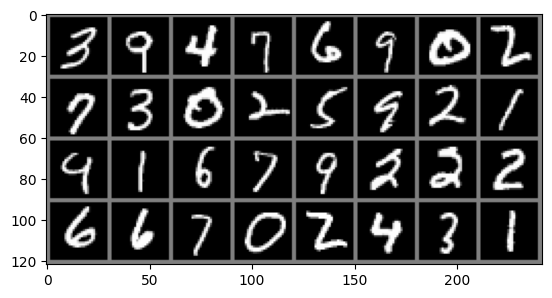

    3     9     4     7


In [5]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(4)))

## Lets build out network

- Class Name: `NeuralNetwork`
- Inherits from: `torch.nn.Module`
- Initialization:
  - Creates a fully connected layer (`fc1`) with input size of 28*28 and output size of 128 neurons.
  - Applies ReLU activation function (`relu`).
  - Creates another fully connected layer (`fc2`) with input size of 128 and output size of 64 neurons.
  - Creates the final fully connected layer (`fc3`) with input size of 64 and output size of 10 neurons.
- Forward Method:
  - Reshapes the input tensor `x` into a 2D tensor with size (-1, 28 * 28), where -1 indicates batch size.
  - Applies ReLU activation to the output of the first fully connected layer (`fc1`).
  - Applies ReLU activation to the output of the second fully connected layer (`fc2`).
  - Computes the output of the final fully connected layer (`fc3`).
- Returns: The output tensor representing the predicted class scores.


In [6]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Init the netowrk and choose a loss function and optimizer

- Object Creation:
  - Creates an instance of the `NeuralNetwork` class and assigns it to the variable `net`.
- Loss Function:
  - Defines the loss function as Cross Entropy Loss (`torch.nn.CrossEntropyLoss()`), which is commonly used for multi-class classification tasks.
- Optimizer:
  - Uses Stochastic Gradient Descent (SGD) optimizer (`torch.optim.SGD`) to optimize the parameters of the neural network.
  - Specifies the parameters to be optimized using `net.parameters()`.
  - Sets the learning rate (`lr`) to 0.01 for controlling the step size during optimization.


In [7]:
net = NeuralNetwork()
inputs, targets = next(iter(train_loader))
net(inputs)

tensor([[-6.8219e-03, -2.0925e-01,  8.4563e-02, -1.4918e-01, -9.6477e-02,
         -6.1806e-02,  4.2577e-02, -6.0432e-02,  6.6599e-02,  5.9623e-02],
        [ 3.9200e-02, -2.0204e-01,  3.4610e-02, -1.5421e-01, -9.6580e-02,
         -1.0798e-01,  1.2473e-01, -8.5468e-02,  4.5737e-02,  1.4305e-01],
        [ 8.2314e-03, -1.6597e-01,  1.2048e-01, -7.9499e-02, -6.2161e-02,
         -1.1728e-01,  7.4181e-02, -1.2989e-01,  1.5253e-01,  1.2139e-01],
        [-7.4871e-05, -3.1900e-01,  6.8931e-02, -1.6335e-01, -4.6331e-03,
         -7.9110e-02,  1.2198e-01, -5.2408e-02, -7.5506e-03,  9.2781e-02],
        [-6.9974e-02, -1.9792e-01,  1.4918e-01, -3.3577e-02, -1.1295e-01,
         -1.6232e-01,  5.8990e-02, -1.2828e-01,  1.2149e-01,  9.9131e-02],
        [-2.9612e-02, -1.6743e-01,  5.9205e-02, -4.9941e-02, -8.3984e-02,
         -1.0778e-01,  4.1057e-02, -1.6484e-01,  7.6534e-02,  1.0834e-01],
        [ 3.9141e-03, -1.9499e-01,  4.7390e-02, -9.4106e-02, -1.0913e-01,
         -1.1039e-01, -1.9519e-0

## Train the network

- Training Loop:
  - `for epoch in range(5):`: Loops over the dataset for a specified number of epochs (5 in this case).
  - `running_loss = 0.0`: Initializes the running loss variable to zero at the start of each epoch.
  - `for i, data in enumerate(train_loader, 0):`: Loops over the batches of data in the training dataset using `enumerate(train_loader, 0)`.
    - `inputs, labels = data`: Unpacks the input data and labels from the batch.
    - `optimizer.zero_grad()`: Clears the gradients of all optimized parameters before backward pass.
    - `outputs = net(inputs)`: Performs forward pass to get the predicted outputs from the neural network.
    - `loss = criterion(outputs, labels)`: Calculates the loss between the predicted outputs and the ground truth labels using the specified criterion (CrossEntropyLoss).
    - `loss.backward()`: Backpropagates the loss gradient through the network's parameters.
    - `optimizer.step()`: Updates the parameters of the model using the gradients computed in the backward pass.
    - `running_loss += loss.item()`: Accumulates the loss for the current batch.
  - `print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))`: Prints the average loss for the epoch, calculated by dividing the total accumulated loss by the number of batches in the training dataset.
  - `running_loss = 0.0`: Resets the running loss variable to zero for the next epoch.
- After Training:
  - Prints "Finished Training" after completing all epochs.


In [8]:
def train_model(model, optimizer):
  criterion = torch.nn.CrossEntropyLoss()
  train_loss = []
  val_loss = []
  for epoch in range(25):  # Loop over the dataset multiple times
      running_loss = 0.0
      running_acc = 0.0
      running_val_loss = 0.0
      running_val_acc = 0.0
      correct = 0
      total = 0
      model.train()
      for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

      running_acc = correct / total
      running_loss = running_loss / len(train_loader)
      model.eval()
      ## model validaiton
      with torch.no_grad():
        for data in val_loader:
          inputs, labels = data
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          running_val_loss += loss.item()
          # Calculate training accuracy
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      running_val_acc = correct / total
      running_val_loss = running_val_loss / len(val_loader)
      train_loss.append(running_loss)
      val_loss.append(running_val_loss)
      # Print the loss, accuracy, and F1 score after each epoch
      print('[%d] loss: %.3f |  Val loss: %.3f | acc: %.2f  | Val acc: %.2f | ' % (epoch + 1, running_loss, running_val_loss, running_acc, running_val_acc))
  return train_loss, val_loss, model

def test_model(model):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  print('Testing accuracy is: %d %%' % (100 * correct / total))

[1] loss: 2.314 |  Val loss: 2.307 | acc: 0.10  | Val acc: 0.10 | 
[2] loss: 2.307 |  Val loss: 2.304 | acc: 0.10  | Val acc: 0.10 | 
[3] loss: 2.307 |  Val loss: 2.304 | acc: 0.11  | Val acc: 0.11 | 
[4] loss: 2.307 |  Val loss: 2.310 | acc: 0.10  | Val acc: 0.10 | 
[5] loss: 2.307 |  Val loss: 2.307 | acc: 0.11  | Val acc: 0.11 | 
[6] loss: 2.307 |  Val loss: 2.308 | acc: 0.11  | Val acc: 0.11 | 
[7] loss: 2.307 |  Val loss: 2.304 | acc: 0.10  | Val acc: 0.11 | 
[8] loss: 2.307 |  Val loss: 2.308 | acc: 0.10  | Val acc: 0.10 | 
[9] loss: 2.307 |  Val loss: 2.303 | acc: 0.10  | Val acc: 0.10 | 
[10] loss: 2.307 |  Val loss: 2.305 | acc: 0.10  | Val acc: 0.11 | 
[11] loss: 2.307 |  Val loss: 2.303 | acc: 0.11  | Val acc: 0.11 | 
[12] loss: 2.307 |  Val loss: 2.304 | acc: 0.11  | Val acc: 0.10 | 
[13] loss: 2.307 |  Val loss: 2.305 | acc: 0.10  | Val acc: 0.10 | 
[14] loss: 2.307 |  Val loss: 2.308 | acc: 0.10  | Val acc: 0.10 | 
[15] loss: 2.307 |  Val loss: 2.307 | acc: 0.11  | Val ac

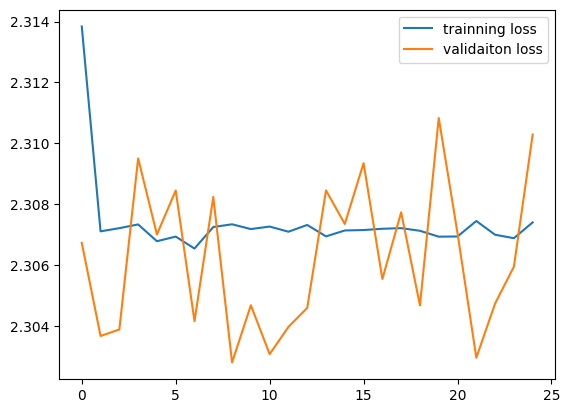

In [9]:
# Let expereiemtn high learning rate
net = NeuralNetwork()
optimizer = torch.optim.SGD(net.parameters(), lr=0.8)
train_loss, val_loss, model = train_model(net, optimizer)
test_model(model)
plt.plot(train_loss, label='trainning loss')
plt.plot(val_loss, label='validaiton loss')
plt.legend()
plt.show()

[1] loss: 2.303 |  Val loss: 2.303 | acc: 0.09  | Val acc: 0.09 | 
[2] loss: 2.303 |  Val loss: 2.302 | acc: 0.09  | Val acc: 0.09 | 
[3] loss: 2.303 |  Val loss: 2.302 | acc: 0.09  | Val acc: 0.09 | 
[4] loss: 2.302 |  Val loss: 2.302 | acc: 0.09  | Val acc: 0.09 | 
[5] loss: 2.302 |  Val loss: 2.302 | acc: 0.09  | Val acc: 0.09 | 
[6] loss: 2.302 |  Val loss: 2.301 | acc: 0.09  | Val acc: 0.09 | 
[7] loss: 2.302 |  Val loss: 2.301 | acc: 0.09  | Val acc: 0.09 | 
[8] loss: 2.301 |  Val loss: 2.301 | acc: 0.09  | Val acc: 0.09 | 
[9] loss: 2.301 |  Val loss: 2.301 | acc: 0.09  | Val acc: 0.10 | 
[10] loss: 2.301 |  Val loss: 2.300 | acc: 0.10  | Val acc: 0.10 | 
[11] loss: 2.301 |  Val loss: 2.300 | acc: 0.10  | Val acc: 0.10 | 
[12] loss: 2.301 |  Val loss: 2.300 | acc: 0.10  | Val acc: 0.10 | 
[13] loss: 2.300 |  Val loss: 2.300 | acc: 0.10  | Val acc: 0.10 | 
[14] loss: 2.300 |  Val loss: 2.300 | acc: 0.10  | Val acc: 0.10 | 
[15] loss: 2.300 |  Val loss: 2.299 | acc: 0.10  | Val ac

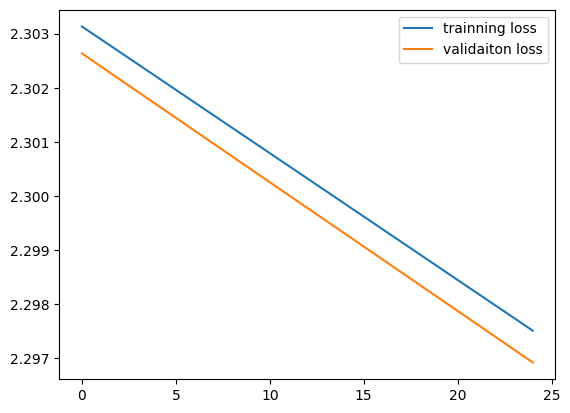

In [10]:
# Let expereiemtn high learning rate
net = NeuralNetwork()
optimizer = torch.optim.SGD(net.parameters(), lr=0.000001)
train_loss, val_loss, model = train_model(net, optimizer)
test_model(model)
plt.plot(train_loss, label='trainning loss')
plt.plot(val_loss, label='validaiton loss')
plt.legend()
plt.show()

[1] loss: 0.786 |  Val loss: 0.365 | acc: 0.78  | Val acc: 0.80 | 
[2] loss: 0.338 |  Val loss: 0.297 | acc: 0.90  | Val acc: 0.90 | 
[3] loss: 0.286 |  Val loss: 0.258 | acc: 0.92  | Val acc: 0.92 | 
[4] loss: 0.248 |  Val loss: 0.237 | acc: 0.93  | Val acc: 0.93 | 
[5] loss: 0.215 |  Val loss: 0.202 | acc: 0.94  | Val acc: 0.94 | 
[6] loss: 0.191 |  Val loss: 0.184 | acc: 0.94  | Val acc: 0.94 | 
[7] loss: 0.170 |  Val loss: 0.169 | acc: 0.95  | Val acc: 0.95 | 
[8] loss: 0.153 |  Val loss: 0.160 | acc: 0.95  | Val acc: 0.95 | 
[9] loss: 0.139 |  Val loss: 0.150 | acc: 0.96  | Val acc: 0.96 | 
[10] loss: 0.127 |  Val loss: 0.143 | acc: 0.96  | Val acc: 0.96 | 
[11] loss: 0.117 |  Val loss: 0.138 | acc: 0.97  | Val acc: 0.96 | 
[12] loss: 0.108 |  Val loss: 0.126 | acc: 0.97  | Val acc: 0.97 | 
[13] loss: 0.100 |  Val loss: 0.130 | acc: 0.97  | Val acc: 0.97 | 
[14] loss: 0.093 |  Val loss: 0.117 | acc: 0.97  | Val acc: 0.97 | 
[15] loss: 0.086 |  Val loss: 0.121 | acc: 0.97  | Val ac

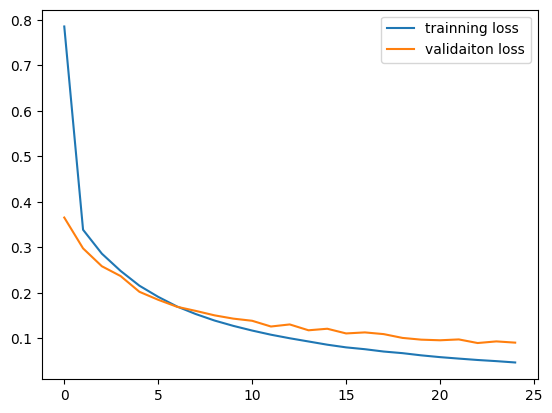

In [11]:
# Let expereiemtn high learning rate
net = NeuralNetwork()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
train_loss, val_loss, model = train_model(net, optimizer)
test_model(model)
plt.plot(train_loss, label='trainning loss')
plt.plot(val_loss, label='validaiton loss')
plt.legend()
plt.show()

## Pytorch [optimizers](https://pytorch.org/docs/stable/optim.html)

[1] loss: 0.390 |  Val loss: 0.212 | acc: 0.88  | Val acc: 0.89 | 
[2] loss: 0.191 |  Val loss: 0.150 | acc: 0.94  | Val acc: 0.94 | 
[3] loss: 0.140 |  Val loss: 0.139 | acc: 0.96  | Val acc: 0.96 | 
[4] loss: 0.117 |  Val loss: 0.112 | acc: 0.96  | Val acc: 0.96 | 
[5] loss: 0.102 |  Val loss: 0.141 | acc: 0.97  | Val acc: 0.97 | 
[6] loss: 0.086 |  Val loss: 0.125 | acc: 0.97  | Val acc: 0.97 | 
[7] loss: 0.078 |  Val loss: 0.114 | acc: 0.97  | Val acc: 0.97 | 
[8] loss: 0.071 |  Val loss: 0.102 | acc: 0.98  | Val acc: 0.98 | 
[9] loss: 0.063 |  Val loss: 0.102 | acc: 0.98  | Val acc: 0.98 | 
[10] loss: 0.058 |  Val loss: 0.118 | acc: 0.98  | Val acc: 0.98 | 
[11] loss: 0.056 |  Val loss: 0.111 | acc: 0.98  | Val acc: 0.98 | 
[12] loss: 0.050 |  Val loss: 0.104 | acc: 0.98  | Val acc: 0.98 | 
[13] loss: 0.050 |  Val loss: 0.106 | acc: 0.98  | Val acc: 0.98 | 
[14] loss: 0.045 |  Val loss: 0.118 | acc: 0.98  | Val acc: 0.98 | 
[15] loss: 0.043 |  Val loss: 0.100 | acc: 0.99  | Val ac

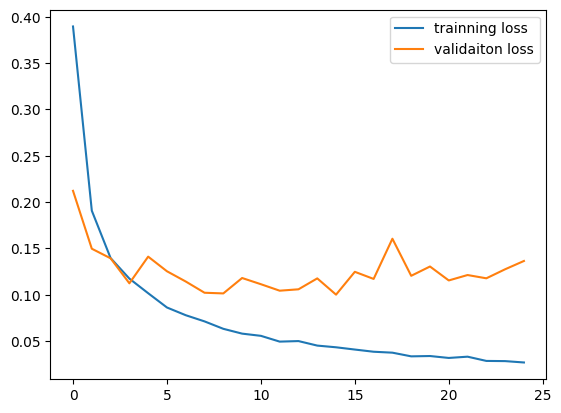

In [12]:
# Let expereiemtn high learning rate
net = NeuralNetwork()
optimizer = torch.optim.Adam(net.parameters())
train_loss, val_loss, model = train_model(net, optimizer)
test_model(model)
plt.plot(train_loss, label='trainning loss')
plt.plot(val_loss, label='validaiton loss')
plt.legend()
plt.show()

## The model architecture

[1] loss: 0.577 |  Val loss: 0.364 | acc: 0.83  | Val acc: 0.84 | 
[2] loss: 0.350 |  Val loss: 0.344 | acc: 0.90  | Val acc: 0.90 | 
[3] loss: 0.322 |  Val loss: 0.305 | acc: 0.91  | Val acc: 0.91 | 
[4] loss: 0.299 |  Val loss: 0.309 | acc: 0.91  | Val acc: 0.91 | 
[5] loss: 0.286 |  Val loss: 0.285 | acc: 0.92  | Val acc: 0.92 | 
[6] loss: 0.277 |  Val loss: 0.295 | acc: 0.92  | Val acc: 0.92 | 
[7] loss: 0.272 |  Val loss: 0.280 | acc: 0.92  | Val acc: 0.92 | 
[8] loss: 0.265 |  Val loss: 0.284 | acc: 0.92  | Val acc: 0.92 | 
[9] loss: 0.262 |  Val loss: 0.269 | acc: 0.92  | Val acc: 0.92 | 
[10] loss: 0.259 |  Val loss: 0.266 | acc: 0.92  | Val acc: 0.92 | 
[11] loss: 0.255 |  Val loss: 0.274 | acc: 0.93  | Val acc: 0.93 | 
[12] loss: 0.252 |  Val loss: 0.277 | acc: 0.93  | Val acc: 0.93 | 
[13] loss: 0.249 |  Val loss: 0.276 | acc: 0.93  | Val acc: 0.93 | 
[14] loss: 0.247 |  Val loss: 0.262 | acc: 0.93  | Val acc: 0.93 | 
[15] loss: 0.246 |  Val loss: 0.286 | acc: 0.93  | Val ac

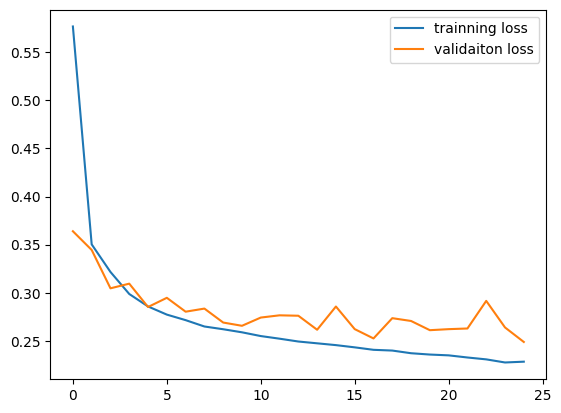

In [13]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 10)
        self.fc2 = torch.nn.Linear(10, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Let expereiemtn high learning rate
net = NeuralNetwork()
optimizer = torch.optim.Adam(net.parameters())
train_loss, val_loss, model = train_model(net, optimizer)
test_model(model)
plt.plot(train_loss, label='trainning loss')
plt.plot(val_loss, label='validaiton loss')
plt.legend()
plt.show()

[1] loss: 0.306 |  Val loss: 0.222 | acc: 0.91  | Val acc: 0.91 | 
[2] loss: 0.147 |  Val loss: 0.144 | acc: 0.96  | Val acc: 0.96 | 
[3] loss: 0.111 |  Val loss: 0.131 | acc: 0.97  | Val acc: 0.96 | 
[4] loss: 0.092 |  Val loss: 0.105 | acc: 0.97  | Val acc: 0.97 | 
[5] loss: 0.079 |  Val loss: 0.115 | acc: 0.98  | Val acc: 0.97 | 
[6] loss: 0.068 |  Val loss: 0.108 | acc: 0.98  | Val acc: 0.98 | 
[7] loss: 0.061 |  Val loss: 0.128 | acc: 0.98  | Val acc: 0.98 | 
[8] loss: 0.055 |  Val loss: 0.108 | acc: 0.98  | Val acc: 0.98 | 
[9] loss: 0.052 |  Val loss: 0.126 | acc: 0.98  | Val acc: 0.98 | 
[10] loss: 0.045 |  Val loss: 0.116 | acc: 0.98  | Val acc: 0.98 | 
[11] loss: 0.043 |  Val loss: 0.108 | acc: 0.99  | Val acc: 0.98 | 
[12] loss: 0.041 |  Val loss: 0.105 | acc: 0.99  | Val acc: 0.98 | 
[13] loss: 0.037 |  Val loss: 0.113 | acc: 0.99  | Val acc: 0.98 | 
[14] loss: 0.032 |  Val loss: 0.102 | acc: 0.99  | Val acc: 0.99 | 
[15] loss: 0.036 |  Val loss: 0.130 | acc: 0.99  | Val ac

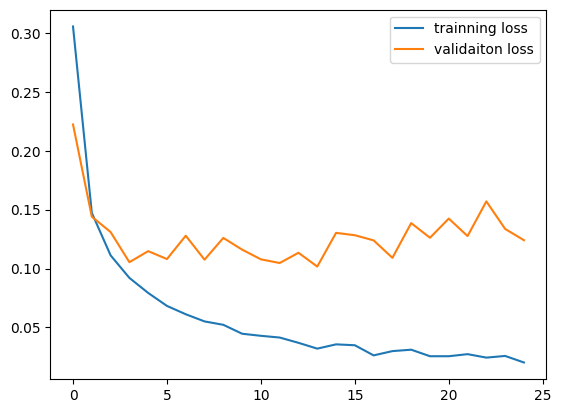

In [14]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 1000)
        self.fc2 = torch.nn.Linear(1000, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Let expereiemtn high learning rate
net = NeuralNetwork()
optimizer = torch.optim.Adam(net.parameters())
train_loss, val_loss, model = train_model(net, optimizer)
test_model(model)
plt.plot(train_loss, label='trainning loss')
plt.plot(val_loss, label='validaiton loss')
plt.legend()
plt.show()

[1] loss: 0.483 |  Val loss: 0.443 | acc: 0.86  | Val acc: 0.86 | 
[2] loss: 0.410 |  Val loss: 0.422 | acc: 0.88  | Val acc: 0.88 | 
[3] loss: 0.385 |  Val loss: 0.345 | acc: 0.89  | Val acc: 0.89 | 
[4] loss: 0.376 |  Val loss: 0.346 | acc: 0.89  | Val acc: 0.90 | 
[5] loss: 0.363 |  Val loss: 0.362 | acc: 0.90  | Val acc: 0.90 | 
[6] loss: 0.354 |  Val loss: 0.369 | acc: 0.90  | Val acc: 0.90 | 
[7] loss: 0.352 |  Val loss: 0.380 | acc: 0.90  | Val acc: 0.90 | 
[8] loss: 0.345 |  Val loss: 0.366 | acc: 0.90  | Val acc: 0.90 | 
[9] loss: 0.345 |  Val loss: 0.418 | acc: 0.90  | Val acc: 0.90 | 
[10] loss: 0.343 |  Val loss: 0.335 | acc: 0.90  | Val acc: 0.90 | 
[11] loss: 0.333 |  Val loss: 0.343 | acc: 0.91  | Val acc: 0.91 | 
[12] loss: 0.341 |  Val loss: 0.352 | acc: 0.90  | Val acc: 0.90 | 
[13] loss: 0.336 |  Val loss: 0.346 | acc: 0.91  | Val acc: 0.91 | 
[14] loss: 0.335 |  Val loss: 0.352 | acc: 0.91  | Val acc: 0.91 | 
[15] loss: 0.333 |  Val loss: 0.336 | acc: 0.91  | Val ac

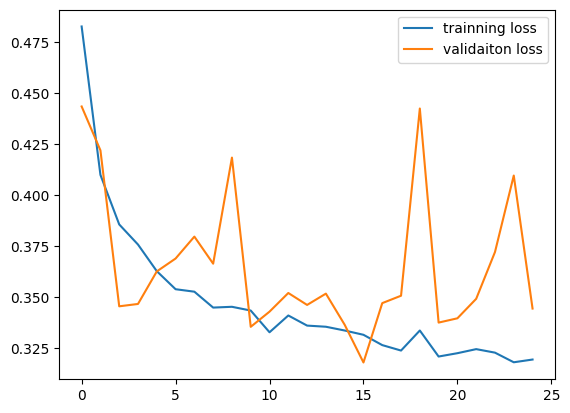

In [15]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 1000)
        self.fc2 = torch.nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Let expereiemtn high learning rate
net = NeuralNetwork()
optimizer = torch.optim.Adam(net.parameters())
train_loss, val_loss, model = train_model(net, optimizer)
test_model(model)
plt.plot(train_loss, label='trainning loss')
plt.plot(val_loss, label='validaiton loss')
plt.legend()
plt.show()

### Weights intialization

In PyTorch, there are several ways to initialize model weights. Proper initialization of weights is crucial for the convergence and performance of deep learning models. Here are some common methods:

Default Initialization: PyTorch initializes weights by default using a method called "Kaiming Initialization" (also known as "He Initialization" for ReLU activations). This initialization is performed by default for linear and convolutional layers.

Using Initializers from torch.nn.init: PyTorch provides various initialization methods in the torch.nn.init module, such as Xavier initialization (xavier_uniform_, xavier_normal_), uniform initialization (uniform_), normal initialization (normal_), etc. You can directly use these initializers to initialize the weights of your layers

In [16]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def init_weights(self):
        # Xavier initialization for fc1
        torch.nn.init.xavier_uniform_(self.fc1.weight.data)
        # Normal initialization for fc2
        torch.nn.init.normal_(self.fc2.weight.data, mean=0, std=0.01)


[1] loss: 0.378 |  Val loss: 0.220 | acc: 0.89  | Val acc: 0.90 | 
[2] loss: 0.179 |  Val loss: 0.143 | acc: 0.95  | Val acc: 0.95 | 
[3] loss: 0.137 |  Val loss: 0.133 | acc: 0.96  | Val acc: 0.96 | 
[4] loss: 0.113 |  Val loss: 0.116 | acc: 0.96  | Val acc: 0.96 | 
[5] loss: 0.092 |  Val loss: 0.106 | acc: 0.97  | Val acc: 0.97 | 
[6] loss: 0.083 |  Val loss: 0.113 | acc: 0.97  | Val acc: 0.97 | 
[7] loss: 0.075 |  Val loss: 0.119 | acc: 0.98  | Val acc: 0.97 | 
[8] loss: 0.067 |  Val loss: 0.111 | acc: 0.98  | Val acc: 0.98 | 
[9] loss: 0.062 |  Val loss: 0.108 | acc: 0.98  | Val acc: 0.98 | 
[10] loss: 0.059 |  Val loss: 0.102 | acc: 0.98  | Val acc: 0.98 | 
[11] loss: 0.053 |  Val loss: 0.093 | acc: 0.98  | Val acc: 0.98 | 
[12] loss: 0.048 |  Val loss: 0.123 | acc: 0.98  | Val acc: 0.98 | 
[13] loss: 0.045 |  Val loss: 0.110 | acc: 0.99  | Val acc: 0.98 | 
[14] loss: 0.042 |  Val loss: 0.105 | acc: 0.99  | Val acc: 0.98 | 
[15] loss: 0.040 |  Val loss: 0.126 | acc: 0.99  | Val ac

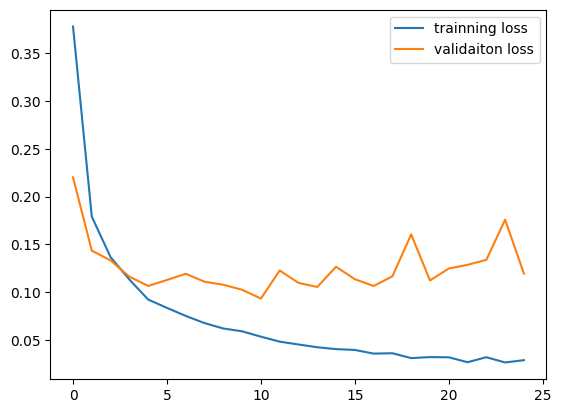

In [17]:
# Let expereiemtn high learning rate
net = NeuralNetwork()
optimizer = torch.optim.Adam(net.parameters())
train_loss, val_loss, model = train_model(net, optimizer)
test_model(model)
plt.plot(train_loss, label='trainning loss')
plt.plot(val_loss, label='validaiton loss')
plt.legend()
plt.show()